# Processing mutations

The variant calls from the BreSeq pipeline are parsed and analysed. All strains with _mutX_ mutations are excluded as they accumulate SNPs at a very high rate, masking interesting mutations.

Mutations that are present in all strains are also excluded as they have most likely also been in the background strain, prior to the evolution experiments.

In [1]:
import pandas as pd
import json
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
compounds = ["HMDA", "putrescine", "1,2-propanediol", "2,3-butanediol", "glutarate", "adipate", "hexanoate",
             "octanoate", "coumarate", "isobutyrate", "butanol", "no_chemical"
            ]

mapping = pd.read_csv("../Data/Mutation_data/Variant_calls/mapping.csv", header=None)
compound_mapping = {
    1: "butanol",
    2: "glutarate",
    3: "coumarate",
    5: "HMDA",
    6: "putrescine",
    7: "adipate",
    8: "isobutyrate",
    9: "hexanoate",
    10: "2,3-butanediol",
    11: "1,2-propanediol",
    12: "octanoate",
    13: "no_chemical"
}
rev_compound_mapping = {v: k for k, v in compound_mapping.items()}

In [4]:
code_to_compound = {
    "BUT": "butanol",
    "GLUT": "glutarate",
    "COUM": "coumarate",
    "HMDA": "HMDA",
    "PUTR": "putrescine",
    "ADIP": "adipate",
    "IBUA": "isobutyrate",
    "HEXA": "hexanoate",
    "23BD": "2,3-butanediol",
    "12PD": "1,2-propanediol",
    "OCTA": "octanoate",
    "GLU":"no_chemical"
}
comp_to_code = {v: k for k, v in code_to_compound.items()}

In [5]:
code_to_compound

{'BUT': 'butanol',
 'GLUT': 'glutarate',
 'COUM': 'coumarate',
 'HMDA': 'HMDA',
 'PUTR': 'putrescine',
 'ADIP': 'adipate',
 'IBUA': 'isobutyrate',
 'HEXA': 'hexanoate',
 '23BD': '2,3-butanediol',
 '12PD': '1,2-propanediol',
 'OCTA': 'octanoate',
 'GLU': 'no_chemical'}

Generate a mutation id from the information from BreSeq.


In [6]:
def generate_mut_id(row):
    typ = row["Mutation Type"]
    pos = str(int(row["Position"].replace(",", "")))
    if typ == "SNP":
        last = row["Sequence Change"][-1]
    elif typ == "DEL":
        if "(" in row["Sequence Change"]:
            last = str(len(row["Sequence Change"].split(")")[0][1:]))
        else:
            last = str(int(row["Sequence Change"][1:-3].replace(",", "")))
    elif typ == "INS":
        if "(" in row["Sequence Change"]:
            last = row["Sequence Change"].split(")")[0][1:]
        else:
            last = row["Sequence Change"][1:]
    elif typ == "MOB":
        fields = row["Sequence Change"].split("\xa0")
        if len(fields)==1: #handling excdptions for NaCl and Glu samples
            fields = str(fields[0]).split(" ")
        last = fields[0] + "-" + fields[2][1:]
    elif typ == "DUP":
        times = row["Sequence Change"].split("x")[-1]
        size = row["Sequence Change"].split(" bp ")[0]
        last = size + "_" + times
    else:
        last = ""
    return "-".join((typ, pos, last))

Convert the strain code from the breseq results to the real strain names using the mapping file.

In [7]:
def strain_code_to_name(strain_code, compound):
    compound_num = rev_compound_mapping[compound]
    fields = strain_code.split(" ")[-4:]
    fields = [f[1:] for f in fields]
    code = (int(fields[0]), int(fields[2]), int(fields[3]))
    strain = mapping[mapping[0] == compound_num].groupby(by=[1, 2, 3]).first().loc[code][4]
    return strain

In [8]:
def convert_to_int(string):
    if string[0] == "‑": # Weird non-standard minus sign
        string = "-" + string[1:] # Replace with normal minus sign
    return int(string)

def pick_gene(rel_coords):
    """Given relative coordinates of an intergenic mutation, pick the gene that is closest downstream"""
    if min(rel_coords) > 0:
        return None
    elif max(rel_coords) <= 0:
        if rel_coords[0] > rel_coords[1]:
            return 0
        else:
            return 1
    elif rel_coords[0] <= 0:
        return 0
    elif rel_coords[1] <= 0:
        return 1
    else:
        raise RuntimeError("What else is there?")

In [9]:
excluded_mutations = {
    'DEL-1299499-1199', # Randomly called across populations DEL ychE/oppA intergenic(+254/-485)
}

In [10]:
strain_to_muts = {}
mut_to_genes = {}
mut_to_change = {}
mut_to_seq = {}
mut_to_full_details = {}

for comp in compounds:
    df = pd.read_csv("../Data/Mutation_data/Variant_calls/%s.csv" % comp)    
    df["mut_id"] = df.apply(generate_mut_id, 1)
    
    for idx, row in df.iterrows():
        genes = row["Gene"]
        if "genes" in genes:
            genes = genes.split("genes")[-1] # Fix inconsistent format for large deletions
        genes = genes.split(", ")
        genes = [gene.strip("[] >") for gene in genes]
        change = row["Protein change"]
        if isinstance(change, str) and change.startswith("intergenic"):
            nums = change.split("(")[1][:-1].split("/")
            nums = convert_to_int(nums[0]), convert_to_int(nums[1])
            nearest = pick_gene(nums)
            if nearest is None:
                genes = []
            else:
                genes = [genes[nearest]]
                
        mut_id = row["mut_id"]
        mut_to_genes[mut_id] = genes
        mut_to_change[mut_id] = change
        mut_to_seq[mut_id] = row['Sequence Change']
        mut_to_full_details[mut_id] = row['Protein change']
        
    for strain_code in df.columns[10:]:
        if strain_code == "mut_id":
            continue
        strain = strain_code_to_name(strain_code, comp)
        if strain.endswith("-rerun"):
            strain = strain[:-6]

        muts = list(df[df[strain_code] == 1]["mut_id"])
        strain_to_muts[strain] = set(muts)  - excluded_mutations # "-rerun" samples overwrite original samples

In [11]:
with open("../Data/Mutation_data/Mutation_sequence_changes.json", "w") as outfile:
    json.dump(mut_to_seq, outfile)
with open("../Data/Mutation_data/Mutation_protein_changes.json", "w") as outfile:
    json.dump(mut_to_full_details, outfile)

In [12]:
mapping.to_csv("../Data/Mutation_data/Variant_calls/mapping_hgl.csv")

In [13]:
# Save the protein effect of all SNP mutations
mut_effects = {}
for mut, change in mut_to_change.items():
    typ = mut.split("-")[0]
    if typ == "SNP":
        if "intergenic" in change:
            effect = "intergenic"
        elif "pseudogene" in change:
            effect = "pseudogene"
        else:
            subs = change.split()[0]
            effect = subs
    else:
        effect = ""
        if change == change and typ != "DUP":
            effect = change.split()[0]
            # print(typ, change)
    mut_effects[mut] = (typ, effect)
    
with open("../Data/Mutation_data/Mutation_effects.json", "w") as outfile:
    json.dump(mut_effects, outfile)

In [14]:
print(
    "There are",
    len(strain_to_muts),
    "strains with a total of",
    len(set.union(*strain_to_muts.values())), "mutations."
)

There are 232 strains with a total of 4059 mutations.


In [15]:
strain_to_genes = {}

# Add genes that are specifically mutated (mutation only has 1 gene target)
for strain, muts in strain_to_muts.items():
    for mut in muts:
        if len(mut_to_genes[mut]) == 1:
            strain_to_genes.setdefault(strain, []).append(mut_to_genes[mut][0])
            
strain_to_genes = {k: set(v) for k, v in strain_to_genes.items()}

certain_mutations = {
    comp: set.union(*(v for k, v in strain_to_genes.items() if k.startswith(comp))) for comp in code_to_compound
}
strain_to_all_genes = copy.deepcopy(strain_to_genes)

# For mutations that affect multiple genes: only add genes that are already mutated in strains from that compound
# (or mutator genes)
for comp in code_to_compound:
    for strain in (s for s in strain_to_muts if s.startswith(comp)):
        for mut in strain_to_muts[strain]:
            if mut.startswith("DUP"):
                continue
            if len(mut_to_genes[mut]) > 1:
                for gene in mut_to_genes[mut]:
                    strain_to_all_genes[strain].add(gene)
                    if gene in certain_mutations[comp] or gene.startswith("mut"):
                        strain_to_genes[strain].add(gene)

In [16]:
print(
    "A total of",
    len(set.union(*strain_to_all_genes.values())),
    "genes are mutated."
)

A total of 2126 genes are mutated.


In [17]:
# Create an overview table of mutations in all strains
mut_df = pd.DataFrame({s: {m: 1 for m in muts} for s, muts in strain_to_muts.items()}).fillna(0).astype("int")
mut_df.to_csv("../Data/Mutation_data/strain_mutation_table.tsv", sep="\t")

In [18]:
# Hypermutators are strains with mutations in a mutX gene
hypermutators = [s for s, genes in strain_to_genes.items() if "mut" in set(g[:3] for g in genes)]
non_hypermutators = set(strain_to_genes) - set(hypermutators)

In [19]:
print(
    "There are",
    len(non_hypermutators),
    "non-mutator strains with a total of",
    len(set.union(*[v for k, v in strain_to_muts.items() if k in non_hypermutators])),
    "mutations affecting",
    len(set.union(*[v for k, v in strain_to_all_genes.items() if k in non_hypermutators])),
    "genes."
)

There are 199 non-mutator strains with a total of 1020 mutations affecting 397 genes.


In [20]:
with open("../Data/Mutation_data/Strain_to_genes.json", "w") as outfile:
    json.dump({k: list(v) for k, v in strain_to_genes.items() if k in non_hypermutators}, outfile)
    
with open("../Data/Mutation_data/Strain_to_all_genes.json", "w") as outfile:
    json.dump({k: list(v) for k, v in strain_to_all_genes.items() if k in non_hypermutators}, outfile)
    
with open("../Data/Mutation_data/All_strains_to_gene_names.json", "w") as outfile:
    json.dump({k: list(v) for k, v in strain_to_genes.items()}, outfile)
    
with open("../Data/Mutation_data/All_strains_to_mutations.json", "w") as outfile:
    json.dump({k: list(v) for k, v in strain_to_muts.items()}, outfile)
    
with open("../Data/Mutation_data/All_mutated_genes.txt", "w") as outfile:
    mutated_genes = set.union(*[strain_to_genes[s] for s in non_hypermutators])
    outfile.write("\n".join(mutated_genes))
    
with open("../Data/Mutation_data/Mutations_to_gene_names.json", "w") as outfile:
    json.dump({k: v for k, v in mut_to_genes.items()}, outfile)

In [21]:
print("Number of mutations in each of the strains classified as a hypermutator:")
for s in sorted(hypermutators):
    print(s, len(strain_to_genes[s]), sep=" \t")

Number of mutations in each of the strains classified as a hypermutator:
12PD1-10 	134
12PD1-2 	146
12PD1-4 	112
12PD2-8 	157
12PD2-9 	158
12PD3-10 	147
12PD3-7 	134
12PD3-8 	179
12PD4-8 	93
12PD4-9 	94
12PD5-1 	132
12PD5-3 	132
12PD7-5 	108
12PD7-6 	193
12PD8-10 	154
12PD8-6 	151
12PD8-7 	136
23BD3-3 	280
23BD3-4 	241
23BD3-9 	263
ADIP5-2 	215
ADIP5-6 	181
GLU5-1 	207
HMDA4-2 	45
HMDA4-6 	47
HMDA4-9 	44
HMDA6-3 	85
HMDA6-7 	87
IBUA3-2 	42
OCTA6-5 	106
OCTA6-6 	107
OCTA6-7 	109


In [22]:
hypermutators_df = pd.DataFrame(hypermutators, columns=["strain_code"])
hypermutators_df.to_csv("../Data/Mutation_data/hypermutators_list.csv",index=False)

(0.0, 26.0)

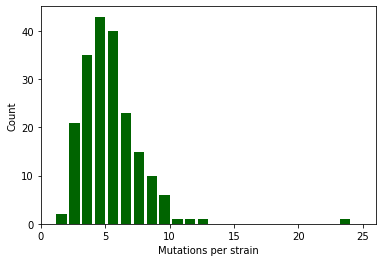

In [23]:
mutation_dict = {s: set(m for m in muts if not m.startswith("DUP")) for s, muts in strain_to_muts.items()}
bins = np.bincount([len(mutation_dict[s]) for s in non_hypermutators])
plt.bar(np.array(range(len(bins))) - 0.4, bins, color="darkgreen")
plt.xlabel("Mutations per strain")
plt.ylabel("Count")
plt.xlim(0, 26)

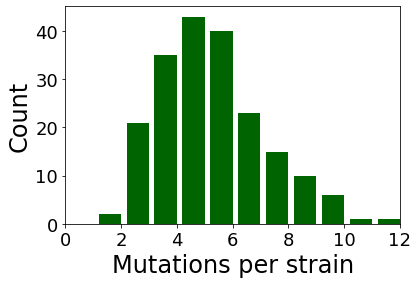

In [24]:
mutation_dict = {s: set(m for m in muts if not m.startswith("DUP")) for s, muts in strain_to_muts.items()}
bins = np.bincount([len(mutation_dict[s]) for s in non_hypermutators if s != "GLUT7-7"])
plt.bar(np.array(range(len(bins))) - 0.4, bins, color="darkgreen")
plt.xlabel("Mutations per strain", fontsize=24)
plt.ylabel("Count", fontsize=24)
plt.xlim([0, 12])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("../Plots/Supplementary - Strain mutation histogram.svg")

(0.0, 40.0)

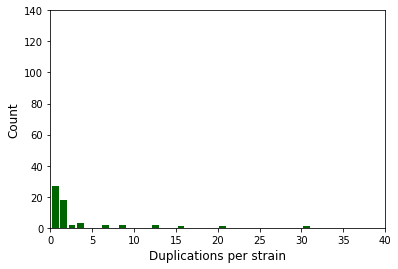

In [25]:
num_dups = [len([m for m in muts if m.startswith("DUP")]) for s, muts in strain_to_muts.items() if s in non_hypermutators]
bins = np.bincount(num_dups)
plt.bar(np.array(range(len(bins))) - 0.4, bins, color="darkgreen")
plt.xlabel("Duplications per strain", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.ylim([0, 140])
plt.xlim([0, 40])
#plt.savefig("../Plots/Supplementary - Strain duplication histogram.svg")

In [26]:
duplication_lengths = {}
for s, muts in strain_to_muts.items():
    dup_sum = 0
    for mut in muts:
        if mut.startswith("DUP"):
            dup_sum += int("".join(mut.split("-")[2].split("_")[0].split(",")))
    duplication_lengths[s] = dup_sum

In [27]:
# Create an overview table of mutations in all strains
mut_df = pd.DataFrame({s: {m: 1 for m in muts} for s, muts in strain_to_muts.items()}).fillna(0).astype("int")
mut_df.to_csv("../Data/Mutation_data/strain_mutation_table.tsv", sep="\t")

In [28]:
print(
    "There are",
    len(non_hypermutators),
    "non-mutator strains with a total of",
    len(set.union(*[v for k, v in strain_to_muts.items() if k in non_hypermutators])),
    "mutations affecting",
    len(set.union(*[v for k, v in strain_to_all_genes.items() if k in non_hypermutators])),
    "genes."
)

There are 199 non-mutator strains with a total of 1020 mutations affecting 397 genes.


In [29]:
non_hypermutators

{'12PD4-6',
 '12PD6-3',
 '12PD6-9',
 '23BD1-6',
 '23BD1-9',
 '23BD2-4',
 '23BD2-7',
 '23BD2-9',
 '23BD4-3',
 '23BD4-4',
 '23BD4-7',
 '23BD5-1',
 '23BD5-10',
 '23BD5-7',
 '23BD6-1',
 '23BD7-4',
 '23BD7-5',
 '23BD7-7',
 '23BD8-2',
 '23BD8-7',
 'ADIP1-1',
 'ADIP1-9',
 'ADIP2-10',
 'ADIP2-5',
 'ADIP2-6',
 'ADIP3-2',
 'ADIP3-4',
 'ADIP3-8',
 'ADIP4-8',
 'ADIP6-10',
 'ADIP6-3',
 'ADIP6-9',
 'ADIP7-2',
 'ADIP7-5',
 'ADIP8-10',
 'ADIP8-3',
 'ADIP8-7',
 'BUT1-2',
 'BUT1-3',
 'BUT1-5',
 'BUT2-9',
 'BUT3-3',
 'BUT3-6',
 'BUT3-7',
 'BUT4-4',
 'BUT4-7',
 'BUT4-9',
 'BUT5-2',
 'BUT5-3',
 'BUT6-1',
 'BUT6-3',
 'BUT6-8',
 'BUT7-6',
 'BUT7-7',
 'BUT7-9',
 'BUT9-10',
 'BUT9-7',
 'COUM1-2',
 'COUM2-3',
 'COUM2-4',
 'COUM2-7',
 'COUM3-1',
 'COUM3-10',
 'COUM3-9',
 'COUM4-10',
 'COUM4-2',
 'COUM4-5',
 'COUM5-3',
 'COUM5-5',
 'COUM5-8',
 'COUM6-2',
 'COUM6-5',
 'COUM6-9',
 'COUM7-5',
 'COUM7-6',
 'COUM8-1',
 'COUM8-6',
 'GLU1-1',
 'GLU2-1',
 'GLU3-1',
 'GLU4-1',
 'GLU6-1',
 'GLU7-1',
 'GLU8-1',
 'GLUT1-10',